# Skillfactory. Курс "Специализация Data Science"
## Дипломный проект. Учебный кейс «Модель прогнозирования стоимости жилья для агентства недвижимости»

**Описание признаков в обработанном наборе данных:**
- 'status' — статус продажи
- 'propertyType' — тип объекта недвижимости
- 'baths' — количество ванных комнат
- 'city' — город
- 'sqft' — площадь в футах
- 'zipcode' — почтовый индекс
- 'beds' — количество спален
- 'state' — штат
- 'stories' — количество этажей
- 'private_pool_bool' - наличие бассейна
- 'fireplace_bool' — наличие камина
- 'last_renovation_year' - год постройки либо последней модернизации объекта
- 'heating_bool' - наличие системы отопления
- 'cooling_bool' - наличие системы кондиционирования
- 'parking_bool' - наличие парковки
- 'school_rating' - средний рейтинг школ вблизи объекта недвижимости
- 'school_distance' - минимальное рассотояние до школы от объекта недвижимости
____________________________
- **'target'** — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2

In [2]:
df = pd.read_csv('data/data_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368969 entries, 0 to 368968
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                368969 non-null  object 
 1   propertyType          368969 non-null  object 
 2   baths                 368969 non-null  int64  
 3   city                  368969 non-null  object 
 4   sqft                  368969 non-null  float64
 5   zipcode               368969 non-null  int64  
 6   beds                  368969 non-null  int64  
 7   state                 368969 non-null  object 
 8   stories               368969 non-null  int64  
 9   target                368969 non-null  int64  
 10  private_pool_bool     368969 non-null  bool   
 11  fireplace_bool        368969 non-null  bool   
 12  last_renovation_year  368969 non-null  int64  
 13  heating_bool          368969 non-null  bool   
 14  cooling_bool          368969 non-null  bool   
 15  

### 2. EDA (Exploratory Data Analysis) — разведывательный анализ данных

**Baseline-решение**  

Прежде чем приступить к разведывательному анализу, мы можем подготовить baseline-решение нашей задачи предсказания на основе обработанного набора данных.
Для базового решения будем использовать алгоритмы линейной регрессии и градиентного бустинга. После этапа EDA будем производить моделирование с помощью других алгоритмов машинного обучения и пытаться улучшить результат относительно baseline.

Для оценки качества моделирования будем использовать следующие метрики:  
- **MAE** - средняя абсолютная ошибка. Показывает насколько в среднем число в предсказании разошлось с реальным числом.
- **MAPE** - средняя абсолютная ошибка в процентах.
- **RMSE** - стандартное отклонение предсказаний от истинных ответов. 
- **R2** - коэффициент детерминации. Помогает понять, какую долю разнообразия смогла уловить модель в данных.  

In [3]:
# Переводим признак zipcode в категориальные
df['zipcode'] = df['zipcode'].astype(str)

# Проверим количество уникальных значений для категориальных признаков
display('Количество уникальных значений в категориальных признаках:',
        df.select_dtypes(include='object').nunique())

'Количество уникальных значений в категориальных признаках:'

status             6
propertyType       7
city            1899
zipcode         4258
state             37
dtype: int64

In [4]:
# Создаем копию датафрейма
df_baseline=df.copy()

# Применяем однократное кодирование для столбцов с количеством категорий менее 15
df_baseline = pd.get_dummies(df_baseline, columns=['status', 'propertyType'])

In [5]:
# Применяем двоичное кодирование для столбцов с количеством категорий более 15
encoder = ce.BinaryEncoder(cols=['state', 'zipcode', 'city'])
encoded_data = encoder.fit_transform(df_baseline[['state', 'zipcode', 'city']])

# Присоединяем к датафрейму закодированные признаки
df_baseline = pd.concat([df_baseline, encoded_data], axis=1)

# Удаляем исходные признаки
df_baseline = df_baseline.drop(['state', 'zipcode', 'city'], axis=1)
df_baseline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368969 entries, 0 to 368968
Data columns (total 56 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   baths                            368969 non-null  int64  
 1   sqft                             368969 non-null  float64
 2   beds                             368969 non-null  int64  
 3   stories                          368969 non-null  int64  
 4   target                           368969 non-null  int64  
 5   private_pool_bool                368969 non-null  bool   
 6   fireplace_bool                   368969 non-null  bool   
 7   last_renovation_year             368969 non-null  int64  
 8   heating_bool                     368969 non-null  bool   
 9   cooling_bool                     368969 non-null  bool   
 10  parking_bool                     368969 non-null  bool   
 11  school_rating                    368969 non-null  float64
 12  sc

In [6]:
# Разделим датафрейм на тренировочную и тестовую выборки
X = df_baseline.drop('target', axis=1)
y = df_baseline['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Проверим размерности
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(295175, 55) (73794, 55) (295175,) (73794,)


In [7]:
# Функция для расчета метрик
def metrics_calculation(y_train, y_train_pred, y_test,y_test_pred):

    # Расчитываем метрики и выводим их на экран
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred)*100
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    r2_train = r2_score(y_train, y_train_pred)

    mae_test = mean_absolute_error(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred)*100
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)

    print('MAE на тренировочной выборке: {:.2f} $'.format(mae_train))
    print('MAPE на тренировочной выборке: {:.2f} %'.format(mape_train))
    print('RMSE на тренировочной выборке: {:.2f} $'.format(rmse_train))
    print('r2 на тренировочной выборке: {:.2f}'.format(r2_train))
        
    print('\nMAE на тестовой выборке: {:.2f} $'.format(mae_test))
    print('MAPE на тестовой выборке: {:.2f} %'.format(mape_test))
    print('RMSE на тестовой выборке: {:.2f} $'.format(rmse_test))
    print('r2 на тестовой выборке: {:.2f}'.format(r2_test))

    # Полученные метрики
    return

In [8]:
# Обучаем модель линейной регрессии
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Выполняем предсказание
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Выводим результаты
metrics_calculation(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочной выборке: 575166.10 $
MAPE на тренировочной выборке: 2452.39 %
RMSE на тренировочной выборке: 1703999.11 $
r2 на тренировочной выборке: 0.15

MAE на тестовой выборке: 575064.84 $
MAPE на тестовой выборке: 2506.07 %
RMSE на тестовой выборке: 1707794.48 $
r2 на тестовой выборке: 0.16


In [9]:
# Обучаем модель градиентного бустинга
gb_regressor = GradientBoostingRegressor(random_state = 42)
gb_regressor.fit(X_train, y_train)

# Выполняем предсказание
y_train_pred = gb_regressor.predict(X_train)
y_test_pred = gb_regressor.predict(X_test)

# Выводим результаты
metrics_calculation(y_train, y_train_pred, y_test, y_test_pred)

MAE на тренировочной выборке: 371143.21 $
MAPE на тренировочной выборке: 1798.23 %
RMSE на тренировочной выборке: 1301169.50 $
r2 на тренировочной выборке: 0.50

MAE на тестовой выборке: 373626.53 $
MAPE на тестовой выборке: 1567.36 %
RMSE на тестовой выборке: 1417970.55 $
r2 на тестовой выборке: 0.42


Как видно из значений метрик, модель градиентного бустинга лучше справилась с задачей и смогла уловить взаимосвязи в данных. Тем не менее, значение ошибки очень велико. На этапе разведывательного анализа нам необходимо улучшить качество данных и в дальнейшем повысить значения предсказаний.

Анализ и обработка числового признака **'target'**.

In [10]:
# Функция вывода гистограммы
def create_hist(feature, name, path):
    fig_hist = px.histogram(
        data_frame=df,
        x=feature,
        marginal="box",
        title=name,
    )
    fig_hist.update_layout(title_x=0.5)
    fig_hist.write_html(path)
    fig_hist.show()
    return

In [11]:
# Функция вывода гистограммы с границами для метода 3-х сигм
def create_hist_with_lines(feature, name, path):
    fig_hist = px.histogram(
        data_frame=df,
        x=feature,
        marginal="box",
        title=name,
    )
    fig_hist.add_vline(
        x=feature.mean(),
        line_color='orange',
        annotation_text='μ'
    )
    fig_hist.add_vline(
        x=feature.mean() + 3*feature.std(),
        line_dash='dash',
        line_color='orange',
        annotation_text='μ+3σ'
    )
    fig_hist.add_vline(
        x=feature.mean() - 3*feature.std(),
        line_dash='dash',
        line_color='orange',
        annotation_text='μ-3σ'
    )
    fig_hist.update_layout(title_x=0.5)
    fig_hist.write_html(path)
    fig_hist.show()
    return

In [12]:
# Функция определения выбросов методом z-отклонений
def outliers_z_score(data, feature, log_scale=False, left=3, right=3, offset=0):
    if log_scale:
        if df[feature].min() > 0: # если значения признака больше 0
            x = np.log(df[feature])
        else:
            x = np.log(df[feature]+1) # иначе добавляем единицу
    else:
        x = df[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left*sigma
    upper_bound = mu + right*sigma
    outliers = data[(x<lower_bound) | (x>upper_bound)]
    cleaned = data[(x>lower_bound) & (x<upper_bound)]
    return outliers, cleaned

In [ ]:
# Гистограмма исходного признака
create_hist('target', 'Распределение цены на объекты недвижимости', 'plotly/target.html')

![](images/target.png?raw=true)

In [ ]:
# Логарифмирование признака
log_feature = np.log(df['target']) # min(target) > 0

# Гистограмма признака в логарифмическом масштабе
create_hist_with_lines(log_feature, 'Распределение цены на объекты недвижимости', 'plotly/target_log.html')

![](images/target_log.png?raw=true)

В логарифмическом масштабе распределение близко к нормальному. Для определения выбросов будем использовать метод z-отклонений (трех сигм). Для снижения количества выбросов уменьшим интервал до 2 сигм.

In [15]:
# Создание таблиц с выбросами и очищенными данными, вывод результатов
outliers, cleaned = outliers_z_score(df, 'target', log_scale=True, right=2, left=2)
display(f'Число выбросов по методу z-отклонений: {outliers.shape[0]}')
display(f'Результирующее число записей: {cleaned.shape[0]}')
df = cleaned

'Число выбросов по методу z-отклонений: 22404'

'Результирующее число записей: 346565'

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 346565 entries, 0 to 368968
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                346565 non-null  object 
 1   propertyType          346565 non-null  object 
 2   baths                 346565 non-null  int64  
 3   city                  346565 non-null  object 
 4   sqft                  346565 non-null  float64
 5   zipcode               346565 non-null  object 
 6   beds                  346565 non-null  int64  
 7   state                 346565 non-null  object 
 8   stories               346565 non-null  int64  
 9   target                346565 non-null  int64  
 10  private_pool_bool     346565 non-null  bool   
 11  fireplace_bool        346565 non-null  bool   
 12  last_renovation_year  346565 non-null  int64  
 13  heating_bool          346565 non-null  bool   
 14  cooling_bool          346565 non-null  bool   
 15  

Анализ и обработка числового признака **'baths'**.

In [ ]:
# Гистограмма исходного признака
create_hist('baths', 'Распределение количества ванных комнат', 'plotly/baths.html')

![](images/baths.png?raw=true)

In [ ]:
# Логарифмирование признака
log_feature = np.log(df['baths']+1)

# Гистограмма признака в логарифмическом масштабе
create_hist_with_lines(log_feature, 'Распределение количества ванных комнат', 'plotly/baths_log.html')

![](images/baths_log.png?raw=true)

В логарифмическом масштабе распределение близко к нормальному. Для определения выбросов будем использовать метод z-отклонений (трех сигм).

In [19]:
# Создание таблиц с выбросами и очищенными данными, вывод результатов
outliers, cleaned = outliers_z_score(df, 'baths', log_scale=True)
display(f'Число выбросов по методу z-отклонений: {outliers.shape[0]}')
display(f'Результирующее число записей: {cleaned.shape[0]}')
df = cleaned

'Число выбросов по методу z-отклонений: 94'

'Результирующее число записей: 346471'

Анализ и обработка числового признака **'sqft'**.

In [ ]:
# Гистограмма исходного признака
create_hist('sqft', 'Распределение объектов недвижимости по площади', 'plotly/sqft.html')

![](images/sqft.png?raw=true)

In [ ]:
# Логарифмирование признака
log_feature = np.log(df['sqft']+1)

# Гистограмма признака в логарифмическом масштабе
create_hist_with_lines(log_feature, 'Распределение объектов недвижимости по площади', 'plotly/sqft_log.html')

![](images/sqft_log.png?raw=true)

В логарифмическом масштабе распределение близко к нормальному. Для определения выбросов будем использовать метод z-отклонений (трех сигм). Для снижения количества выбросов уменьшим интервал до 2 сигм.

In [22]:
# Создание таблиц с выбросами и очищенными данными, вывод результатов
outliers, cleaned = outliers_z_score(df, 'sqft', log_scale=True, left=2, right=2)
display(f'Число выбросов по методу z-отклонений: {outliers.shape[0]}')
display(f'Результирующее число записей: {cleaned.shape[0]}')
df = cleaned

'Число выбросов по методу z-отклонений: 19372'

'Результирующее число записей: 327099'

Анализ и обработка числового признака **'beds'**.

In [ ]:
# Гистограмма исходного признака
create_hist('beds', 'Распределение количества спален', 'plotly/beds.html')

![](images/beds.png?raw=true)

In [ ]:
# Логарифмирование признака
log_feature = np.log(df['beds']+1)

# Гистограмма признака в логарифмическом масштабе
create_hist_with_lines(log_feature, 'Распределение количества спален', 'plotly/beds_log.html')

В логарифмическом масштабе распределение близко к нормальному. Для определения выбросов будем использовать метод z-отклонений (трех сигм).

![](images/beds_log.png?raw=true)

In [25]:
# Создание таблиц с выбросами и очищенными данными, вывод результатов
outliers, cleaned = outliers_z_score(df, 'beds', log_scale=True)
display(f'Число выбросов по методу z-отклонений: {outliers.shape[0]}')
display(f'Результирующее число записей: {cleaned.shape[0]}')
df = cleaned

'Число выбросов по методу z-отклонений: 3008'

'Результирующее число записей: 324091'

Анализ и обработка числового признака **'stories'**.

In [ ]:
# Гистограмма исходного признака
create_hist('stories', 'Распределение количества этажей', 'plotly/stories.html')

![](images/stories.png?raw=true)

In [ ]:
# Логарифмирование признака
log_feature = np.log(df['stories']+1)

# Гистограмма признака в логарифмическом масштабе
create_hist_with_lines(log_feature, 'Распределение количества этажей', 'plotly/stories_log.html')

![](images/stories_log.png?raw=true)

В логарифмическом масштабе распределение близко к нормальному. Для определения выбросов будем использовать метод z-отклонений (трех сигм).

In [28]:
# Создание таблиц с выбросами и очищенными данными, вывод результатов
outliers, cleaned = outliers_z_score(df, 'stories', log_scale=True)
display(f'Число выбросов по методу z-отклонений: {outliers.shape[0]}')
display(f'Результирующее число записей: {cleaned.shape[0]}')
df = cleaned

'Число выбросов по методу z-отклонений: 5240'

'Результирующее число записей: 318851'

Анализ и обработка числового признака **'last_renovation_year'**.

In [29]:
# Проверим значения признка
display(df['last_renovation_year'].sort_values(ascending=True))

# Избавимся от очевидных выбросов
condition = ((df['last_renovation_year'] < 1600) | (df['last_renovation_year'] > 2022))
df.drop(df[condition].index, inplace=True)

121374               0
64468                0
153248               0
33662                0
12158                0
              ...     
109233            2022
161723            2025
307272            2025
76915     559990649990
346672    559990649990
Name: last_renovation_year, Length: 318851, dtype: int64

In [ ]:
# Гистограмма исходного признака
create_hist('last_renovation_year', 'Распределение объектов недвижимости по году строительства/модернизации', 'plotly/last_renovation_year.html')

![](images/last_renovation_year.png?raw=true)

In [ ]:
# Логарифмирование признака
log_feature = np.log(df['last_renovation_year'])

# Гистограмма признака в логарифмическом масштабе
create_hist_with_lines(log_feature, 'Распределение объектов недвижимости по году строительства/модернизации', 'plotly/last_renovation_year_log.html')

![](images/last_renovation_year_log.png?raw=true)

В логарифмическом масштабе распределение не приблизилось к нормальному. Однако с помощью метода z-отклонений мы избавимся от очевидных выбросов. Для снижения количества выбросов сдвинем левую границу до 2 сигм.

In [32]:
# Создание таблиц с выбросами и очищенными данными, вывод результатов
outliers, cleaned = outliers_z_score(df, 'last_renovation_year', log_scale=True, left=2)
display(f'Число выбросов по методу z-отклонений: {outliers.shape[0]}')
display(f'Результирующее число записей: {cleaned.shape[0]}')
df = cleaned

'Число выбросов по методу z-отклонений: 19781'

'Результирующее число записей: 299026'

Анализ и обработка числового признака **'school_rating'**.

In [33]:
# Проверим значения признка
display(df['school_rating'].sort_values(ascending=True))

# Избавимся от отрицательных значений
condition = df['school_rating'] < 0
df.drop(df[condition].index, inplace=True)

20737    -1.0
284245   -1.0
13499    -1.0
333444   -1.0
208306   -1.0
         ... 
37667     9.0
199954    9.0
73424     9.0
167984    9.0
51061     9.0
Name: school_rating, Length: 299026, dtype: float64

In [ ]:
# Гистограмма исходного признака
create_hist('school_rating', 'Распределение среднего рейтинга школ', 'plotly/school_rating.html')

![](images/school_rating.png?raw=true)

In [ ]:
# Логарифмирование признака
log_feature = np.log(df['school_rating']+1)

# Гистограмма признака в логарифмическом масштабе
create_hist_with_lines(log_feature, 'Распределение среднего рейтинга школ', 'plotly/school_rating_log.html')

![](images/school_rating_log.png?raw=true)

В логарифмическом масштабе распределение близко к нормальному. Для определения выбросов будем использовать метод z-отклонений (трех сигм). Для снижения количества выбросов уменьшим интервал до 2 сигм.

In [36]:
# Создание таблиц с выбросами и очищенными данными, вывод результатов
outliers, cleaned = outliers_z_score(df, 'school_rating', log_scale=True, left=2, right=2)
display(f'Число выбросов по методу z-отклонений: {outliers.shape[0]}')
display(f'Результирующее число записей: {cleaned.shape[0]}')
df = cleaned

'Число выбросов по методу z-отклонений: 8926'

'Результирующее число записей: 286945'

Анализ и обработка числового признака **'school_distance'**.

In [37]:
# Проверим значения признка
display(df['school_distance'].sort_values(ascending=True))

# Избавимся от отрицательных значений
condition = df['school_distance'] < 0
df.drop(df[condition].index, inplace=True)

166489      -1.00
201751      -1.00
305936      -1.00
63850       -1.00
337012      -1.00
           ...   
294738     725.20
227596     725.21
200749    1187.14
108705    1590.36
349276    1590.38
Name: school_distance, Length: 286945, dtype: float64

In [ ]:
# Гистограмма исходного признака
create_hist('school_distance', 'Распределение минимального расстояния до школы', 'plotly/school_distance.html')

![](images/school_distance.png?raw=true)

In [ ]:
# Логарифмирование признака
log_feature = np.log(df['school_distance']+1)

# Гистограмма признака в логарифмическом масштабе
create_hist_with_lines(log_feature, 'Распределение минимального расстояния до школы', 'plotly/school_distance_log.html')

![](images/school_distance_log.png?raw=true)

В логарифмическом масштабе распределение не приблизилось к нормальному. Однако с помощью метода z-отклонений мы избавимся от очевидных выбросов. Для снижения количества выбросов сдвинем правую границу до 2 сигм.

In [40]:
# Создание таблиц с выбросами и очищенными данными, вывод результатов
outliers, cleaned = outliers_z_score(df, 'school_distance', log_scale=True, right=2)
display(f'Число выбросов по методу z-отклонений: {outliers.shape[0]}')
display(f'Результирующее число записей: {cleaned.shape[0]}')
df = cleaned

'Число выбросов по методу z-отклонений: 13023'

'Результирующее число записей: 273718'

Мы избавились от выбросов в числовых признаках. Однако ни один из признаков не распределен нормально, следовательно прежде чем подавать данные в модель необходимо произвести операцию нормализации, что будет сделано в дальнейшем.

Оценим мультиколлинеарность числовых признаков.

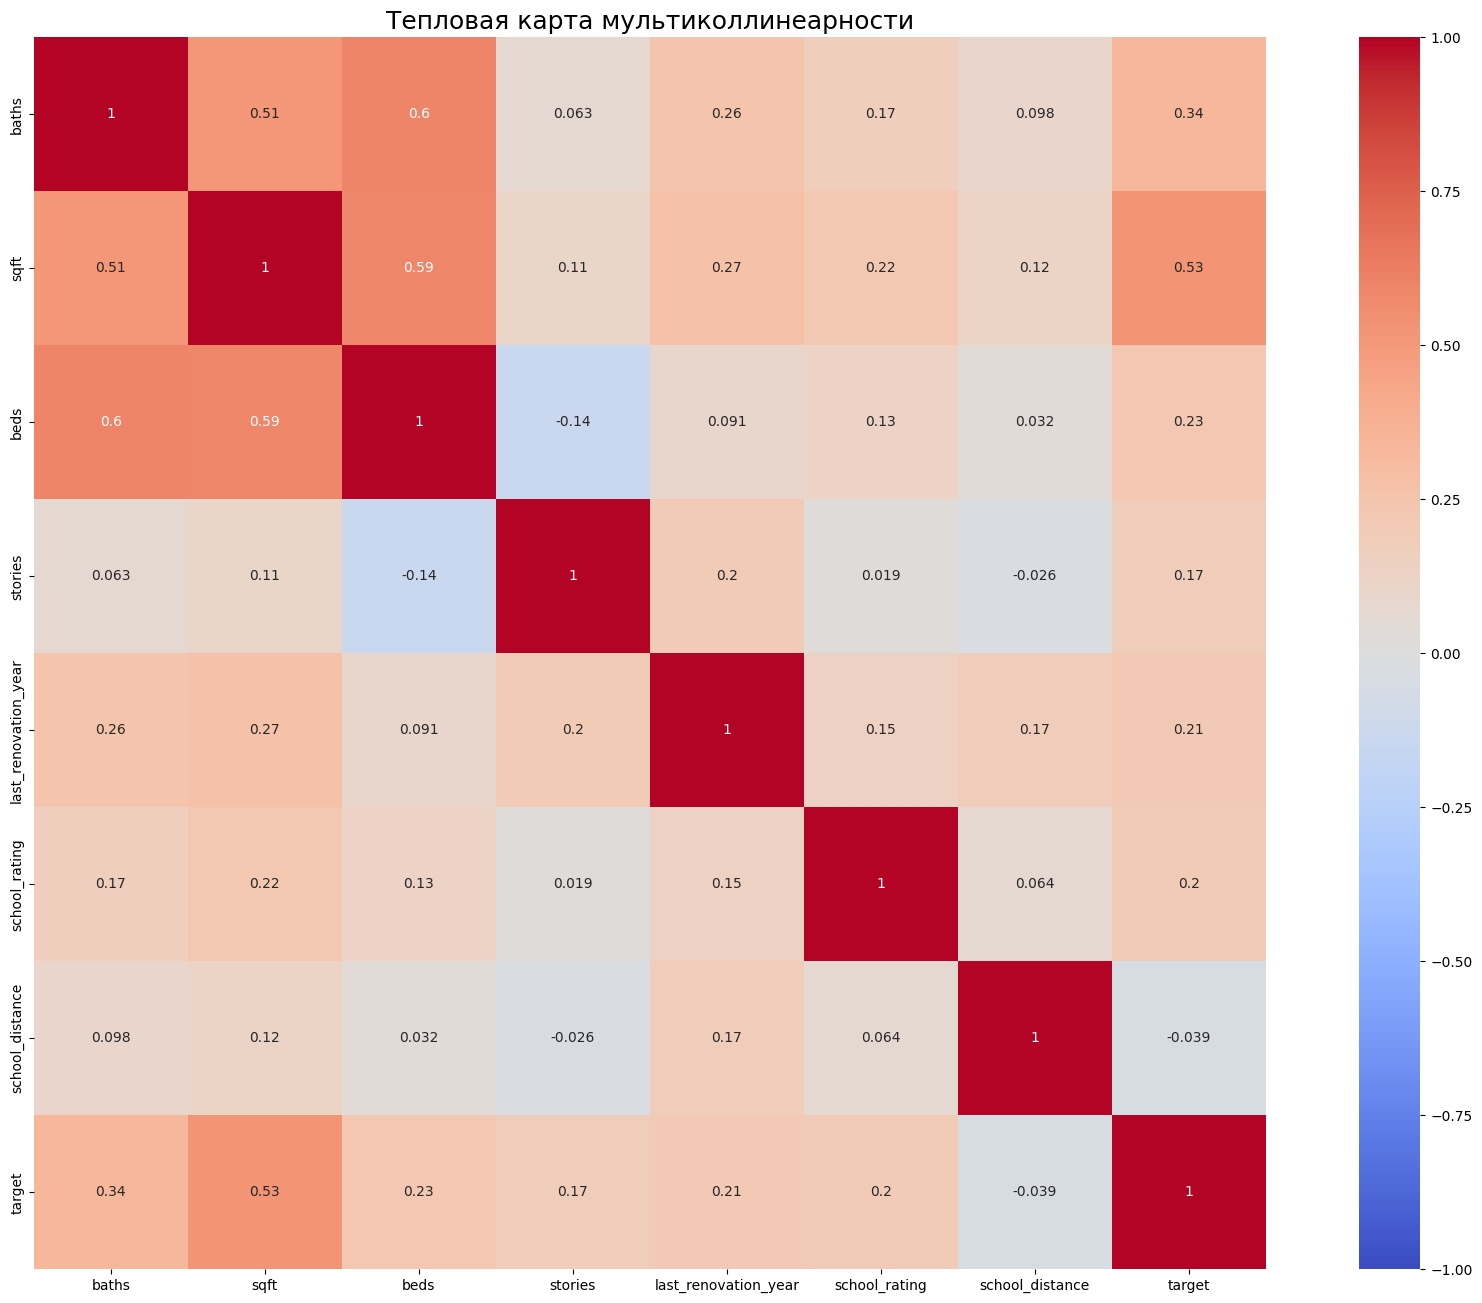

In [41]:
# Составим список числовых признаков
num_features = ['baths', 'sqft', 'beds', 'stories', 'last_renovation_year', 'school_rating', 'school_distance', 'target']

# Построим тепловую карту мультиколлинеарности
fig = plt.figure(figsize=(24, 16))
heatmap = sns.heatmap(
    data = df[num_features].corr(method='spearman'),
    annot = True,
    fmt = '.2g',
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap= 'coolwarm',
    square = True
);
heatmap.set_title('Тепловая карта мультиколлинеарности', fontsize=18);

Т.к. наши числовые признаки распределены ненормально, для оценки мультиколлинеарности применена корреляция Спирмена. Значения корреляции между признаками не превышают 0.6, следовательно мультиколлинеарность между признаками отсутствует.

Построим график попарных отношений для визуализации характера связей между признаками.

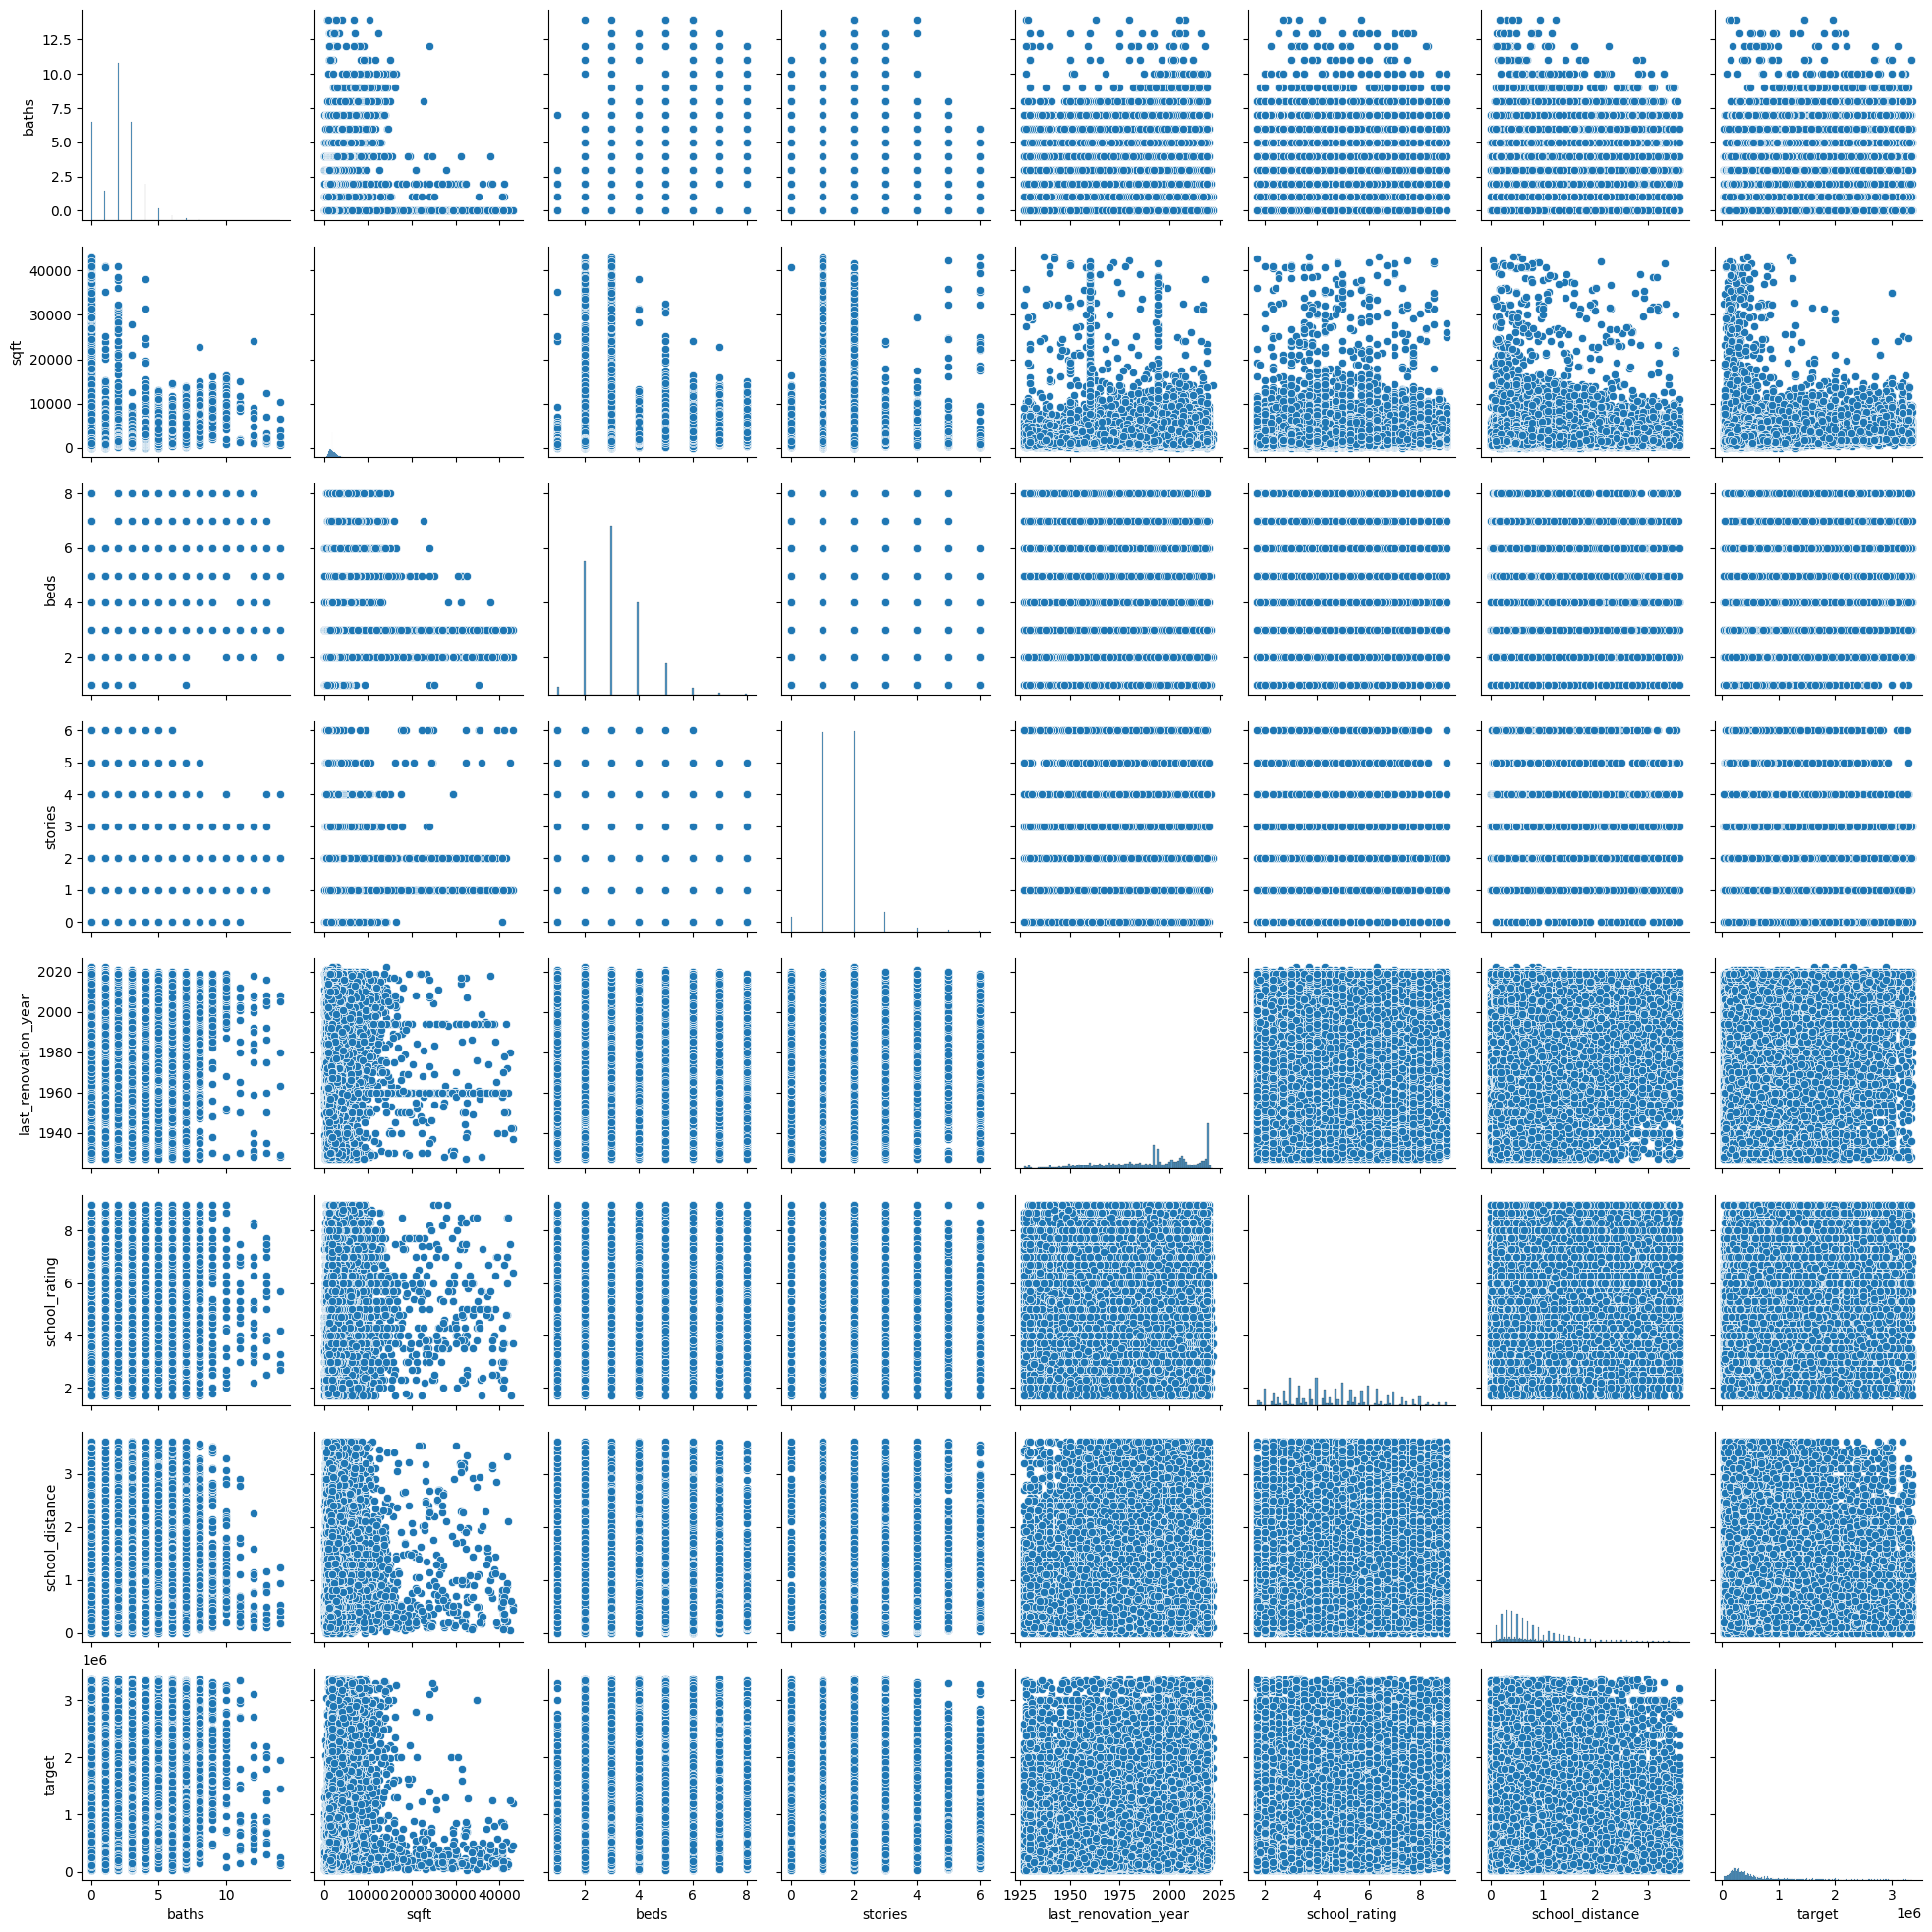

In [42]:
sns.pairplot(df[num_features])

Произведем нормализацию числовых признаков с помощью MinMaxScaler.

In [43]:
# Инициализируем нормализатор MinMaxScaler
mm_scaler = MinMaxScaler()

# Определяем столбцы для нормализации
num_features = ['baths', 'sqft', 'beds', 'stories', 'last_renovation_year', 'school_rating', 'school_distance']

# Сохраняем результаты
df[num_features] = mm_scaler.fit_transform(df[num_features])

# Проверяем результаты
df.describe()


,baths,sqft,beds,stories,target,last_renovation_year,school_rating,school_distance
count,273718.000000,273718.000000,273718.000000,273718.000000,2.737180e+05,273718.000000,273718.000000,273718.000000
mean,0.145737,0.048223,0.297801,0.260010,4.834184e+05,0.660374,0.403899,0.239331
std,0.105453,0.033304,0.149201,0.122057,4.784946e+05,0.243353,0.239057,0.197684
min,0.000000,0.000000,0.000000,0.000000,2.930300e+04,0.000000,0.000000,0.000000
25%,0.071429,0.030034,0.142857,0.166667,2.137500e+05,0.494737,0.219178,0.099723
50%,0.142857,0.040778,0.285714,0.333333,3.300000e+05,0.705263,0.383562,0.168975
75%,0.214286,0.057646,0.428571,0.333333,5.589375e+05,0.842105,0.589041,0.324100
max,1.000000,1.000000,1.000000,1.000000,3.375000e+06,1.000000,1.000000,1.000000


Значения всех числовых признаков, кроме целевого, приведены к диапазону [0...1]

Произведем кодирование категориальных признаков.

In [44]:
# Проверим количество уникальных значений для категориальных признаков
display('Количество уникальных значений в категориальных признаках:',
        df.select_dtypes(include='object').nunique())

'Количество уникальных значений в категориальных признаках:'

status             6
propertyType       7
city            1585
zipcode         3911
state             35
dtype: int64

In [45]:
# Применяем однократное кодирование для столбцов с количеством категорий менее 15
df = pd.get_dummies(df, columns=['status', 'propertyType'])

In [46]:
# Определяем столбцы для кодирования
cat_features = ['state', 'zipcode', 'city']

# Кодируем признаки с помощью LabelEncoder
le_state = LabelEncoder()
state_label = le_state.fit_transform(df['state'])
le_zipcode = LabelEncoder()
zipcode_label = le_zipcode.fit_transform(df['zipcode'])
le_city = LabelEncoder()
city_label = le_city.fit_transform(df['city'])

# Добавляем закодированные столбцы в датафрейм
df['state_label'] = state_label
df['city_label'] = city_label
df['zipcode_label'] = zipcode_label

# Удаляем обработанные столбцы
df.drop(cat_features, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273718 entries, 0 to 368968
Data columns (total 29 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   baths                            273718 non-null  float64
 1   sqft                             273718 non-null  float64
 2   beds                             273718 non-null  float64
 3   stories                          273718 non-null  float64
 4   target                           273718 non-null  int64  
 5   private_pool_bool                273718 non-null  bool   
 6   fireplace_bool                   273718 non-null  bool   
 7   last_renovation_year             273718 non-null  float64
 8   heating_bool                     273718 non-null  bool   
 9   cooling_bool                     273718 non-null  bool   
 10  parking_bool                     273718 non-null  bool   
 11  school_rating                    273718 non-null  float64
 12  sc

Оценим мультиколлинеарность для всех признаков.

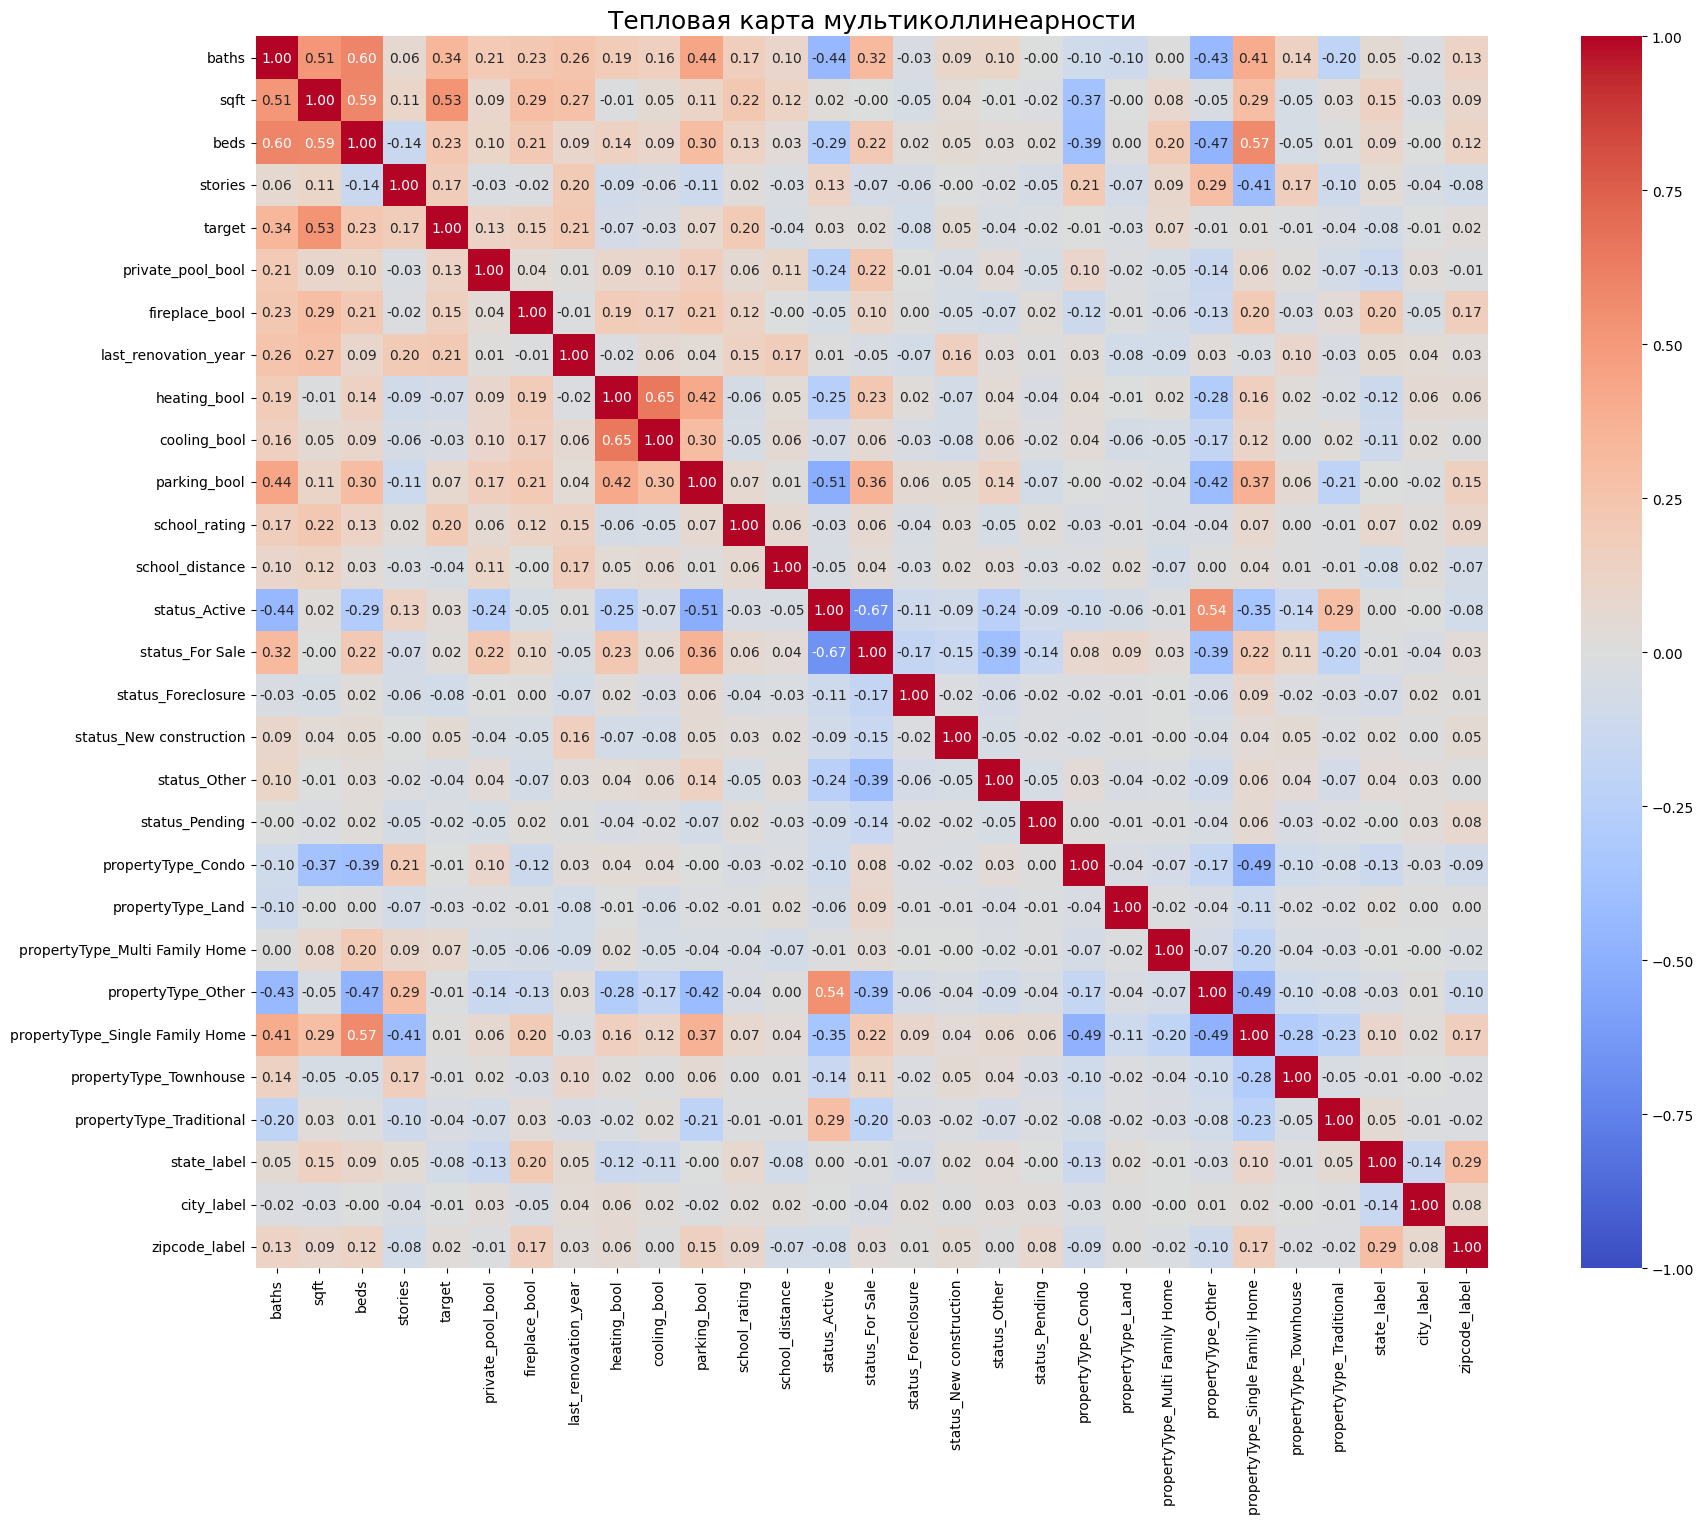

In [47]:
# Построим тепловую карту мультиколлинеарности
fig = plt.figure(figsize=(24, 16))
heatmap = sns.heatmap(
    data = df.corr(method='spearman'),
    annot = True,
    fmt = '.2f',
    vmin = -1,
    vmax = 1,
    center = 0,
    cmap= 'coolwarm',
    square = True
);
heatmap.set_title('Тепловая карта мультиколлинеарности', fontsize=18);

Для оценки мультиколлинеарности применяем корреляцию Спирмена, учитывая что между признаками могут существовать нелинейные связи. Значения корреляции между признаками не выходяз за границы +/- 0.7, следовательно мультиколлинеарность между признаками отсутствует. 

Оценим значимость признаков с помощью SelectKBest. Выберем 20 наиболее значимых признаков.

In [48]:
# Создаем объект класса SelectKBest
k_best = SelectKBest(score_func=f_regression, k=20)

# Получаем список лучших 20 признаков
k_best.fit(df.drop('target', axis=1), df['target'])
k_best_features = k_best.get_feature_names_out()

# Проверяем, какие признаки не вошли в число лучших
display('Признаки, не вошедшие в 20 лучших:', set(df.drop('target', axis=1).columns).difference(set(k_best_features)))

'Признаки, не вошедшие в 20 лучших:'

{'city_label',
 'propertyType_Condo',
 'propertyType_Land',
 'propertyType_Single Family Home',
 'school_distance',
 'status_For Sale',
 'status_Pending',
 'zipcode_label'}

Проведем тест ANOVA для непрерывных признаков. 

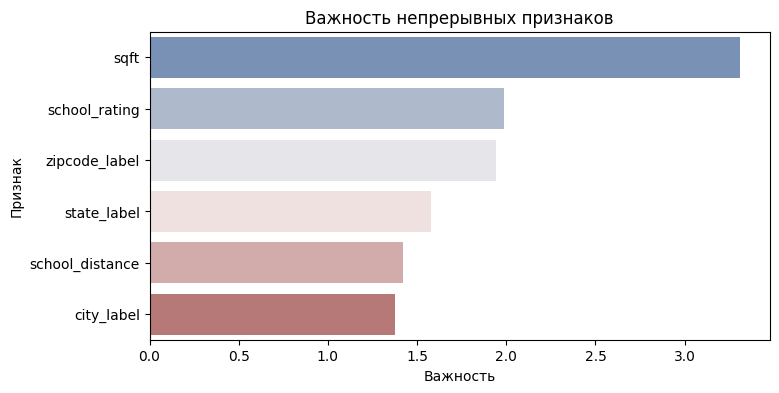

In [49]:
# Тест ANOVA и визуализация результатов
num_cols = ['sqft', 'school_rating', 'school_distance', 'state_label', 'zipcode_label', 'city_label']

feature_importance = pd.Series(f_classif(df[num_cols], df['target'])[0], index = num_cols)
feature_importance = feature_importance.sort_values(ascending=False)

fig = plt.figure(figsize=(8, 4))
barplot = sns.barplot(
    data = feature_importance.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность непрерывных признаков', fontsize = 12);
barplot.set_xlabel('Важность');
barplot.set_ylabel('Признак');

По результатам теста ANOVA наибольшее влияние на стоимость объекта оказывает признак площадь недвижимости. Наименьшую роль играет признак 'city_label'. Он также не вошел в число лучших по результатам SelectKBest, исключим его из набора данных.

In [50]:
df.drop(['city_label'], axis=1, inplace=True)

Выполним хи-квадрат-тест для категориальных признаков. 

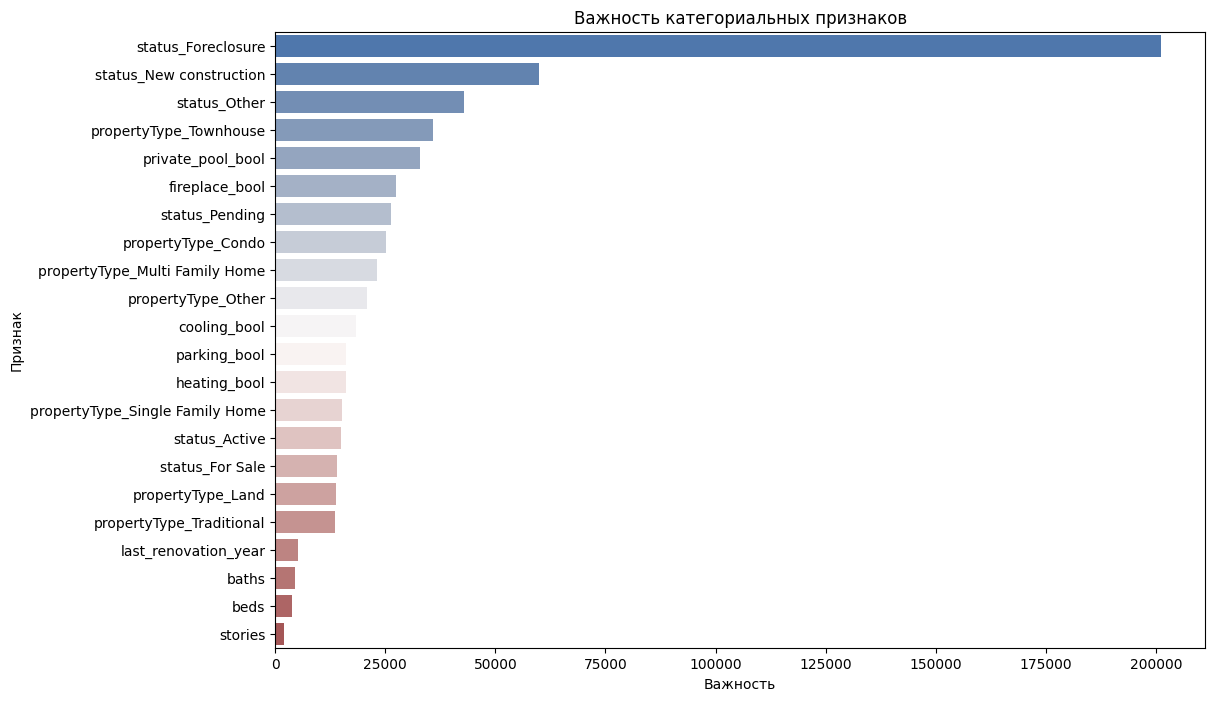

In [51]:
# Хи-квадрат-тест и визуализация результатов
cat_cols = ['baths', 'beds', 'stories', 'private_pool_bool', 'fireplace_bool',
            'last_renovation_year', 'heating_bool', 'cooling_bool',
            'parking_bool', 'status_Active', 'status_For Sale',
            'status_Foreclosure', 'status_New construction', 'status_Other',
            'status_Pending', 'propertyType_Condo', 'propertyType_Land',
            'propertyType_Multi Family Home', 'propertyType_Other', 
            'propertyType_Single Family Home', 'propertyType_Townhouse', 
            'propertyType_Traditional']

feature_importance = pd.Series(chi2(df[cat_cols], df['target'])[0], index=cat_cols)
feature_importance = feature_importance.sort_values(ascending=False)

fig = plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    data = feature_importance.to_frame(name='importance').reset_index(),
    x = 'importance',
    y = 'index',
    orient = 'h',
    palette = 'vlag'
);
barplot.set_title('Важность категориальных признаков', fontsize = 12);
barplot.set_xlabel('Важность');
barplot.set_ylabel('Признак');

Наибольшую важность среди категориальных признаков имеет признак 'status_Foreclosure' (недвижимость, перешедшая к кредитору из-за
неуплаты ипотеки заёмщиком). Можно предположить, что цены на такую недвижимость ниже, следовательно выше спрос. Наименьшую важность имеют признаки 'baths', 'beds', 'stories'. По результатам SelectKBest эти признаки не попали в число худших, оставим их в наборе данных для нашей модели предсказания.

Таким образом, мы завершили работу по обработке данных. На этапах предварительной обработки и EDA мы произвели очистку данных, избавились от выбросов и неинформативных признаков, создали новые признаки для нашей модели предсказания. Теперь мы готовы приступать к процессу обучения моделей.

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273718 entries, 0 to 368968
Data columns (total 28 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   baths                            273718 non-null  float64
 1   sqft                             273718 non-null  float64
 2   beds                             273718 non-null  float64
 3   stories                          273718 non-null  float64
 4   target                           273718 non-null  int64  
 5   private_pool_bool                273718 non-null  bool   
 6   fireplace_bool                   273718 non-null  bool   
 7   last_renovation_year             273718 non-null  float64
 8   heating_bool                     273718 non-null  bool   
 9   cooling_bool                     273718 non-null  bool   
 10  parking_bool                     273718 non-null  bool   
 11  school_rating                    273718 non-null  float64
 12  sc

In [53]:
# Cохраняем обработанные данные в CSV-файл
df.to_csv("data/data_cleaned_for_model.csv", index=False)